# Flows learned solutions and true solutions to nonlinear ICA

The code below tries out aDM on solutions to the nonlinear ICA problem given by normalizing flows.

There is a number of caveats to the current version:

## To do:
- Change the training procedure --- should sweep the whole batch at every epoch;
- Can it be made faster somehow?

### 1. Hard to implement a learnable Darmois construction with flows: 

Many reasons: (i) long training time; (ii) extremely not expressive when constrained to triangular Jacobian (despite proofs of UAC...)
**(iii) training is unstable and sometimes returns nan**. (iv) I train on few datapoints, otherwise it takes forever.
In practice, I am using RealNVP modules (which I think should **not** have UAC).
Concatenating enough modules (with shuffling of the variables in between) the transformation looks almost expressive enough (while **not** having triangular Jacobian).

### 2. Principled way to compare models

In practice, the comparison btwn real solution and flow-learned one only makes sense if the flow **perfectly** fits the data.
This does not happen most of the time anyhow.
Alternatively, one would need a principled way to compare two models based on a combination of their aDM value and likelihood.

### 3. (Related to the above) did the flow learn the "true" solution?

Given that this flows don't have triangular Jacobian, it is in principle possible that they learn the true solution.
Currently, I check that this is not the case by visual inspection --- but this is not very principled. Other ideas?

In [1]:
from jax import numpy as np
from jax import random

import numpy as onp

In [2]:
rng, flow_rng = random.split(random.PRNGKey(0))

/Users/luigigresele/git/projects/ica_and_icm/plotting.py:42: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "papertype" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig(fname, dpi=None, facecolor='w', edgecolor='w',
/Users/luigigresele/git/projects/ica_and_icm/plotting.py:42: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "frameon" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig(fname, dpi=None, facecolor='w', edgecolor='w',


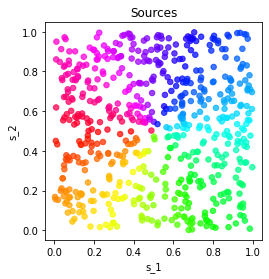

In [3]:
# N:=Number of samples
N = 600
# D:=Number of dimensions
D = 2

# Generate the samples
S = random.uniform(rng, shape=(N, D), minval=0.0, maxval=1.0)


from plotting import cart2pol, scatterplot_variables

_, phi = cart2pol( S[:,0]-0.5, S[:,1]-0.5)

colors = phi

# S-=0.5

scatterplot_variables(S, 'Sources', colors=colors, savefig=True, fname="sources_flow")

In [4]:
# Generate the observations
from mixing_functions import f_1, f_2, f_3, f_lin,  post_nonlinear_model
from jax import vmap

from scipy.stats import ortho_group # Requires version 0.18 of scipy
A = ortho_group.rvs(dim=2)
# mixing, _ = post_nonlinear_model(A)
mixing = f_1
# mixing, _ = f_lin(A)

mixing_batched = vmap(mixing)

X = mixing_batched(S)
X -= np.mean(X, axis=0)

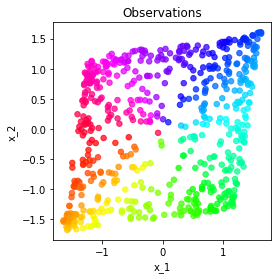

In [5]:
scatterplot_variables(X, 'Observations', colors=colors, savefig=True, fname="observations_flow")

In [6]:
# Insert a lot of code to do wonderful things with Gilles Louppe's Normalizing Flow implementations

In [7]:
from real_nvp import real_nvp_and_inv

realnvp, realnvp_inv = real_nvp_and_inv(D)

In [8]:
from jax import jacfwd

v_realnvp = vmap(realnvp, (0, None, None, None, None))
v_realnvp_inv = vmap(realnvp_inv, (0, None, None, None, None))
J_realnvp = jacfwd(realnvp)
v_J_realnvp = vmap(J_realnvp, (0, None, None, None, None))
vdet = vmap(np.linalg.det)

In [9]:
from real_nvp import nf_init, nf_forward, nf_backward

In [10]:
# Initialize a normalizing flow made of 5 real NVP transformations
d = D//2
nf_nn, nf_params = nf_init(20, rng, d)

In [11]:
from jax.scipy.stats import multivariate_normal

def loss(params, batch):
    z, jacobians = nf_forward(batch, nf_nn, params, forward=v_realnvp, return_jacobians=True, jacobian_function=v_J_realnvp)
    return -np.mean(multivariate_normal.logpdf(z, mean=np.zeros(D), cov=np.eye(D)) + 
                    sum([np.log(np.abs(vdet(J))) for J in jacobians]))

In [12]:
from jax.experimental.optimizers import adam
from jax import grad
from jax import jit


opt_init, opt_update, get_params = adam(step_size=1e-4)
grad_loss = grad(loss, 0)

@jit
def step(i, opt_state, batch):
    params = get_params(opt_state)
    g = grad_loss(params, batch)
    return opt_update(i, g, opt_state)

In [13]:
opt_state = opt_init(nf_params)
save_opt_state = opt_state
best_params = get_params(opt_state)
best_loss = 1e3

In [49]:
iters, batch_size = 400, 125#512
data_generator = (X[onp.random.choice(X.shape[0], batch_size)] for _ in range(iters+1))

In [50]:
opt_state = save_opt_state

In [51]:
import time
start_time = time.time()

In [52]:
for i in range(iters):
    current_minibatch = next(data_generator)
    opt_state = step(i, opt_state, current_minibatch)
    
    # Show progress
    if i % 50 == 0:
        params = get_params(opt_state)
        loss_current = loss(params, current_minibatch)
        print('Epoch: ', i, '; Loss: ', loss_current)
        if loss_current<best_loss:
            best_loss = loss_current
            best_params = get_params(opt_state)
            save_opt_state = opt_state

end_time = time.time()

Epoch:  0 ; Loss:  2.2710261
Epoch:  50 ; Loss:  2.0503886
Epoch:  100 ; Loss:  2.1324668
Epoch:  150 ; Loss:  2.1418808
Epoch:  200 ; Loss:  2.0957649
Epoch:  250 ; Loss:  2.3290527


KeyboardInterrupt: 

In [18]:
print(end_time-start_time)

485.9333281517029


In [53]:
params = best_params #get_params(opt_state)

In [54]:
best_loss #loss(params, X[:100])

DeviceArray(2.0503886, dtype=float32)

In [55]:
loss(params, X)

DeviceArray(2.1111815, dtype=float32)

In [56]:
# Forward and inverse functions

# ...

In [57]:
# Project through the flow
Y = nf_forward(X, nf_nn, params, forward=v_realnvp, return_jacobians=False)

In [58]:
from plotting import scatterplot_variables

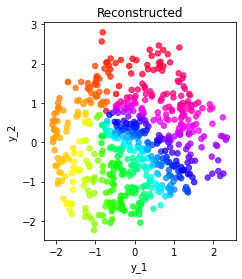

In [59]:
scatterplot_variables(Y, 'Reconstructed', colors=colors, savefig=True, fname="Reconstructed_flow")

In [60]:
from jax.scipy.special import erf
from statsmodels.distributions.empirical_distribution import ECDF

In [61]:
cdf_t = lambda x : 0.5*(1.0 + erf(x))

In [62]:
Y_1 = cdf_t(Y)

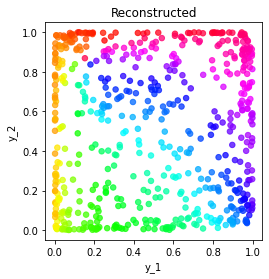

In [63]:
scatterplot_variables(Y_1, 'Reconstructed', colors=colors, savefig=True, fname="Reconstructed_flow_cdf")

In [64]:
X_ = nf_backward(Y, nf_nn, params, v_realnvp_inv)

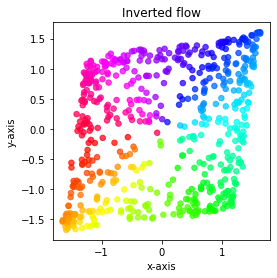

In [65]:
scatterplot_variables(X_, 'Inverted flow', colors=colors)

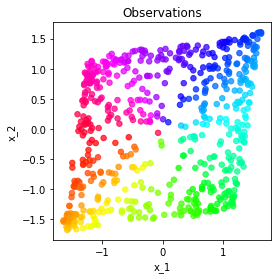

In [66]:
scatterplot_variables(X, 'Observations', colors=colors)

In [67]:
# Implied mixing
mixing_darmois = lambda x : nf_backward(x, nf_nn, params, realnvp_inv)
# mixing_darmois_batched = vmap(mixing_darmois)

In [68]:
Y[0].shape

(2,)

In [69]:
mixing_darmois(Y[0])

DeviceArray([1.3705298, 1.1801629], dtype=float32)

In [70]:
# mixing_darmois(Y[0:1])

In [71]:
from jax import jacfwd

Jflow = jacfwd(mixing_darmois)
# Jflow_batched = vmap(Jflow)

In [72]:
Jflow(Y[0])

DeviceArray([[0.71948314, 0.12965132],
             [2.2076304 , 1.1592008 ]], dtype=float32)

In [73]:
# Jflow(Y[0:1]).reshape(-1, 2, 2)

In [74]:
# Import aDM and stuff
from metrics import aDM

In [75]:
# Compute the batched Jacobian
Jmixing = jacfwd(mixing)
Jmixing_batched = vmap(Jmixing)
# Compute aDM true
true_aDM = aDM(Jmixing_batched, S)

# Build Darmois
# Insert Flow here!

# Sources w. Darmois construction
Y = nf_forward(X, nf_nn, params, forward=v_realnvp, return_jacobians=False)

# Compute the batched Jacobian
Jflow = jacfwd(mixing_darmois)
Jflow_batched = vmap(Jflow)
# Compute aDM for inv Darmois
flow_darmois_aDM = aDM(Jflow_batched, Y)

print(true_aDM)

print(flow_darmois_aDM)

0.09382345
0.7076463


In [42]:
flow_darmois_aDM - true_aDM

DeviceArray(0.63929045, dtype=float32)

In [43]:
# Average Jacobian of the true solution
ave_jac_true = np.mean(Jmixing_batched(S), axis=0)

In [44]:
import matplotlib.pyplot as plt

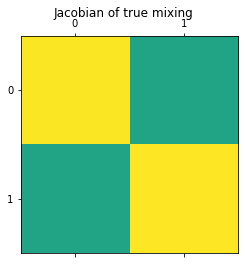

In [45]:
f, ax = plt.subplots(1, 1)
plt.suptitle('Jacobian of true mixing')
m = np.max(np.abs(ave_jac_true))
ax.matshow(ave_jac_true, vmin=-m, vmax=m)
cbar = plt.colorbar
plt.show()

In [46]:
# Average Jacobian of the flow based solution
ave_jac_flow = np.mean(Jflow_batched(Y), axis=0)

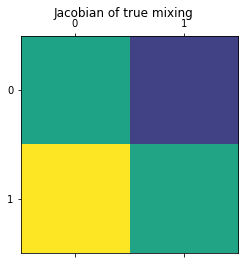

In [47]:
f, ax = plt.subplots(1, 1)
plt.suptitle('Jacobian of true mixing')
m = np.max(np.abs(ave_jac_flow))
ax.matshow(ave_jac_flow, vmin=-m, vmax=m)
plt.show()

## Below, code for training of Normalising Flows based on
https://circleci.com/gh/ChrisWaites/jax-flows

In [8]:
# from flow_models import MAF_init_fun, NeuralSplineCoupling_init_fun

In [9]:
# init_fun, bijection = MAF_init_fun()
# # init_fun, bijection = NeuralSplineCoupling_init_fun()

In [10]:
# params, log_pdf, sample = init_fun(flow_rng, D)

In [11]:
# from jax import jit, grad
# import itertools

# def loss(params, inputs):
#     return -log_pdf(params, inputs).mean()

# # @jit
# def step(i, opt_state, inputs):
#     params = get_params(opt_state)
#     gradients = grad(loss)(params, inputs)
#     return opt_update(i, gradients, opt_state)

# itercount = itertools.count()

In [12]:
# num_epochs, batch_size = 500, 50

In [13]:
# from jax.experimental import optimizers

# opt_init, opt_update, get_params = optimizers.adam(step_size=5*1e-5)
# opt_state = opt_init(params)

In [14]:
# for epoch in range(num_epochs):
# #     clear_output(wait=True) # Clear plotting

#     permute_rng, rng = random.split(rng)
#     X = random.permutation(permute_rng, X)
#     for batch_index in range(0, len(X), batch_size):
#         opt_state = step(next(itercount), opt_state, X[batch_index:batch_index+batch_size])
    
#     if (epoch+1)%10 ==0:
#         params = get_params(opt_state)
#         current_loss = loss(params, X)
#         print("Epoch: ", epoch+1, "; Loss: ", current_loss)